In [1]:
import sys
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers, Sequential
from src.ranking_model import create_ranking_network, create_siamese_ranking_network
from src.feature_extractor import create_vgg19_feature_extractor
from src.utils  import *
from src.dataset import *


# Configs
sys.path.append('../../')
question_id = 1

In [2]:
vgg19_backbone = create_vgg19_feature_extractor()
vgg19_backbone.summary()

Model: "VGG19_Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                           

In [4]:
ranking_network = create_ranking_network(num_dense_layers=2,
                                         dense_units_list=[64,64],
                                         dense_activation_list=['relu','relu'],
                                         dropout_rate_list=[0.4,0.4],
                                         batch_normalization_list=[True,True],
                                         feature_extractor=vgg19_backbone,
                                         img_size=(224,224))
            
ranking_network.summary()

Model: "Ranking_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 Preprocessing_Layers (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 VGG19_Feature_Extractor (Fu  (None, 7, 7, 512)        20024384  
 nctional)                                                       
                                                                 
 Dense_Ranking_Network (Sequ  (None, 1)                1610433   
 ential)                                                         
                                                                 
Total params: 21,634,817
Trainable params: 8,689,601
Non-trainable params: 12,945,216
_______________________________

In [5]:
image_aug_layers = Sequential(
    [
        layers.RandomZoom(0.2),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.4)
    ]
)

siamese_ranking_network = create_siamese_ranking_network(ranking_network=ranking_network,
                                                         image_augmentation_layers=image_aug_layers)
siamese_ranking_network.summary()                                                       

Model: "Siamese_Ranking_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Ranking_Network (Functional)   (None, 1)            21634817    ['input_1[0][0]',                
                                                                  'input_2[0

In [6]:
siamese_ranking_network.compile(optimizer=Adam(learning_rate=0.0001), 
                                loss='binary_crossentropy', 
                                metrics=['accuracy'])

In [7]:
images_dir = '../../data/Mapillary_data/Sample_web_green/' 
duel_results_path = f'../../data/duel_results/duels_question_{question_id}.csv'
img_size = 224  # 224 for VGG19

(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(img_size,duel_results_path, images_dir, model_type='ranking', shuffle=True, shuffle_seed=1)

Number of duels before removing the duplicated duels: 4563
Number of duels after removing the duplicated duels: 4536


Processing Duels: 100%|██████████| 4536/4536 [00:44<00:00, 102.47it/s]


Epoch 1/100
86/86 [==============================] - 12s 98ms/step - loss: 0.7289 - accuracy: 0.7394 - val_loss: 0.5818 - val_accuracy: 0.8214
Epoch 2/100
86/86 [==============================] - 7s 86ms/step - loss: 0.5124 - accuracy: 0.8111 - val_loss: 0.5458 - val_accuracy: 0.8368
Epoch 3/100
86/86 [==============================] - 7s 86ms/step - loss: 0.4790 - accuracy: 0.8159 - val_loss: 0.5349 - val_accuracy: 0.8313
Epoch 4/100
86/86 [==============================] - 7s 85ms/step - loss: 0.4182 - accuracy: 0.8530 - val_loss: 0.4303 - val_accuracy: 0.8258
Epoch 5/100
86/86 [==============================] - 7s 85ms/step - loss: 0.3958 - accuracy: 0.8434 - val_loss: 0.4891 - val_accuracy: 0.8302
Epoch 6/100
86/86 [==============================] - 7s 85ms/step - loss: 0.3570 - accuracy: 0.8677 - val_loss: 0.4492 - val_accuracy: 0.8324
Epoch 7/100
86/86 [==============================] - 7s 85ms/step - loss: 0.3144 - accuracy: 0.8769 - val_loss: 0.7932 - val_accuracy: 0.7927
Epoch

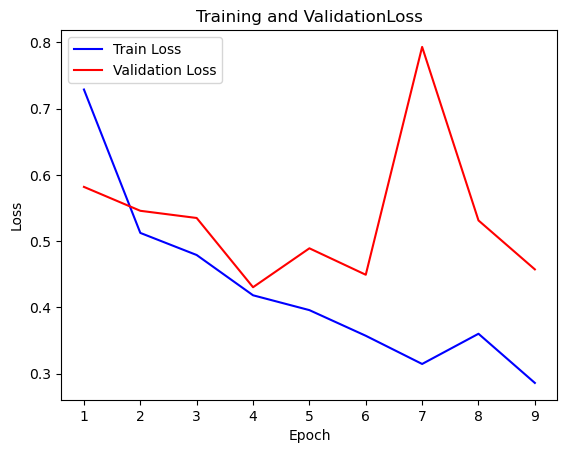

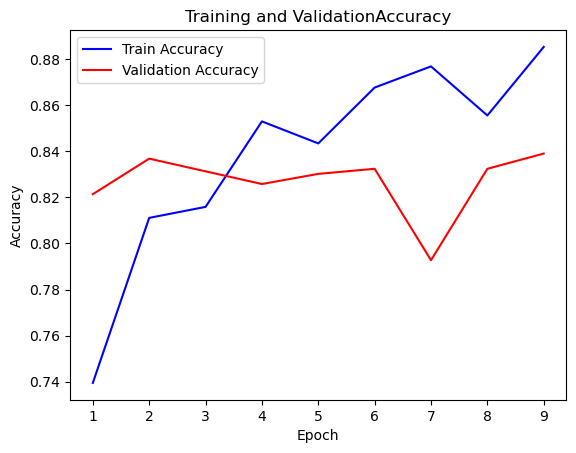

In [8]:
history = siamese_ranking_network.fit(x_train, y_train,
                                      batch_size=32,
                                      epochs=100,
                                      validation_data=(x_val, y_val),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
plot_model_metrics(history, ['loss','accuracy'])

In [8]:
# Test Model
test_loss, test_acc = siamese_ranking_network.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

# Predictions
